In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
from typing import Any
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder, rotation_feature_engineer, accelrometer_feature_engineer
from src.utils.model_utils import evaulate_model, train_model
from src.utils.visualize_utils import plot_cm, get_avg_fold
from src.data_cleaning import normalize_sequence_count, clean_df

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

from scipy.spatial.transform import Rotation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

In [2]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

#! todo toremove the tof_1_v20 part
tof_of_interest = ["tof_1_v20", "tof_2_v26", "tof_3_v17", "tof_4_v5", "tof_5_v20"]
full_df = full_df.drop(columns=[col for col in full_df.columns if col not in tof_of_interest and  col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_3_v17,tof_4_v5,tof_5_v20,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,57.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,68.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,97.0,107.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,151.0,113.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,207.0,121.0,192.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,219.0,93.0,46.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,216.0,82.0,50.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,208.0,83.0,53.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,210.0,91.0,48.0,1,30,0,1,186.0,55,30.0


In [4]:
filtered_df, target_gestures = clean_df(full_df, drop_rot_na=True, drop_thm_na=False)
filtered_df = normalize_sequence_count(filtered_df)

filtered_df = rotation_feature_engineer(filtered_df)
filtered_df = accelrometer_feature_engineer (filtered_df)

filtered_df

[rot_na] Remaining: 254179/574945 (-320766, 55.8% dropped)
[gesture_len outliers] Remaining: 222934/254179 (-31245, 12.3% dropped)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,rotvec_x_diff,rotvec_z_diff,angular_mag,fft_acc_x,fft_acc_y,fft_acc_z,acc_mag,jerk_acc_x,jerk_acc_y,jerk_acc_z
0,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.000000,0.000000,0.000000,29171.0,19688.0,11033.0,9.924192,0.000000,0.000000,0.000000
1,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,-0.003831,-0.028692,0.030410,25.0,61.0,192.0,10.113299,-0.042969,0.117188,0.343750
2,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.032691,0.025619,0.041628,76.0,24.0,66.0,10.536305,0.042969,-0.152344,0.957031
3,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,0.050705,0.046642,0.092412,21.0,0.0,86.0,9.782531,-0.539062,0.343750,-1.187500
4,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,0.014674,0.006900,0.024087,0.0,0.0,1.0,9.925453,0.500000,0.191406,-0.765625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252765,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,-0.010090,-0.038689,0.041088,4.0,6.0,18.0,9.919849,0.882812,-0.578125,-1.683594
252766,SEQ_065531_000052,Non-Target,SEQ_065531,52,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.013186,0.007692,0.020022,3.0,0.0,2.0,10.574324,0.304688,-0.574219,-0.542969
252767,SEQ_065531_000052,Non-Target,SEQ_065531,53,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,0.000000,31.0,4.0,19.0,10.574324,0.000000,0.000000,0.000000
252768,SEQ_065531_000052,Non-Target,SEQ_065531,54,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,0.000000,0.0,0.0,10.0,10.574324,0.000000,0.000000,0.000000


In [5]:
target_df = filtered_df["gesture"]
encoder = load_encoder(encoder_path, target_df)  # type: ignore

features_of_interest = [
    "acc_x",
    "acc_y",
    "acc_z",
    "fft_acc_x",
    "fft_acc_y",
    "fft_acc_z",
    "acc_mag",
    "jerk_acc_x",
    "jerk_acc_y",
    "jerk_acc_z",
    #
    "rotvec_x",
    "rotvec_y",
    "rotvec_z",
    "rot_angle",
    "angular_mag",
    # "tof_1_v20",
    # "thm_2",
    # "thm_4",
    # "thm_5",
]

sequence_groups = filtered_df.groupby("sequence_id")

feature_np = np.array([group for _, group in sequence_groups[features_of_interest]], dtype=np.float32) # N x n_timesteps x n_features
feature_np = feature_np.transpose(0, 2, 1).copy() # N x n_features x n_timestpes
target_np = np.array([encoder.transform(group.unique()) for _, group in sequence_groups["gesture"]])
feature_np.shape

(7222, 15, 35)

In [6]:
# encoder
target_tensor = torch.tensor(target_np, dtype=torch.long).squeeze(1)
target_gestures_encoded = torch.tensor(encoder.transform(target_gestures))

feature_tensor = torch.tensor(feature_np)
feature_tensor.shape, target_tensor.shape

(torch.Size([7222, 15, 35]), torch.Size([7222]))

In [7]:
dummy_input = torch.rand(64, 15, 35)

def get_statistical_info(x: torch.Tensor) -> torch.Tensor:
    """
    x shape: B x n_features x n_timesteps
    """
    
    return torch.concat([
        x.mean(dim=2), # (B x F)
        x.std(dim=2, unbiased=False), # B x F
    ], dim=1) # B x 2F

n_static_outs = get_statistical_info(dummy_input).shape[1] // 15
get_statistical_info(dummy_input).shape

torch.Size([64, 30])

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self, n_channels, n_classes, statistical_outputs):
        super().__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv1d(n_channels, 64, kernel_size=15, stride=5),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm1d(64),
            #
            nn.AdaptiveAvgPool1d(1),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 + (n_channels * statistical_outputs), 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes),
        )

    def forward(self, x: torch.Tensor):
        """
        X shape: N x n_features x time_steps
        """
        x_conv = self.conv_layer(x).squeeze(-1)  # x out_dim
        x_statistics = get_statistical_info(x)  # B x F

        x = torch.concat([x_conv, x_statistics], dim=1)

        y_pred = self.fc(x)

        return y_pred


dummy_model = SimpleModel(15, len(encoder.classes_), n_static_outs)
dummy_model(dummy_input).shape

torch.Size([64, 9])

In [21]:
n_features = feature_tensor.shape[1]
batch_size = 32
n_epochs = 100
n_splits = 5

gkf = GroupKFold(n_splits)

X_test_arr = []
X_train_arr = []
y_train_arr = []
y_test_arr = []

test_subjects = []
folds_score = []

subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=feature_tensor, y=target_tensor, groups=subject_per_sequence)): # type: ignore
    test_subjects.append(np.unique(subject_per_sequence[test_indices]))
    X_train, y_train = feature_tensor[train_indices], target_tensor[train_indices] # B x F x T
    X_test, y_test = feature_tensor[test_indices], target_tensor[test_indices]
    
    mean = X_train.mean(dim=(0, 2)).view(1, -1, 1)   # shape (1xFx1)
    std  = X_train.std(dim=(0, 2), unbiased=False).view(1, -1, 1) + 1e-8  # shape (1xFx1)

    # Normalize
    X_train = (X_train - mean) / std
    X_test  = (X_test  - mean) / std
    
    X_train_arr.append(X_train.cpu().numpy())
    X_test_arr.append(X_test.cpu().numpy())
    y_train_arr.append(y_train.cpu().numpy())
    y_test_arr.append(y_test.cpu().numpy())
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    
    model = SimpleModel(n_features, len(encoder.classes_), n_static_outs).to(device)
    
    model.train()
    train_model(model, dataloader_train, n_epochs, True)

    model.eval()
    y_pred = torch.argmax(model(X_test), dim=1)
    score_dashboard = evaulate_model(y_pred, y_test, target_gestures_encoded, encoder)
    folds_score.append(score_dashboard)

0 - loss_avg: 1.6974143514317044
20 - loss_avg: 0.7974671206092308
40 - loss_avg: 0.5103052952506925
60 - loss_avg: 0.3813942460477023
80 - loss_avg: 0.2544435989832022
0 - loss_avg: 1.7010538340932098
20 - loss_avg: 0.7850653038499105
40 - loss_avg: 0.46409844191364164
60 - loss_avg: 0.3338661689043704
80 - loss_avg: 0.24200665874622804
0 - loss_avg: 1.6994630026293325
20 - loss_avg: 0.7626901660319213
40 - loss_avg: 0.45072165770190104
60 - loss_avg: 0.3116198039439681
80 - loss_avg: 0.222939528340658
0 - loss_avg: 1.6638747493206467
20 - loss_avg: 0.7416320115492488
40 - loss_avg: 0.43759546272497807
60 - loss_avg: 0.32210074480396605
80 - loss_avg: 0.2593884186006218
0 - loss_avg: 1.648168083712541
20 - loss_avg: 0.7502328422517408
40 - loss_avg: 0.47146525118726396
60 - loss_avg: 0.29645240994283506
80 - loss_avg: 0.23284704670392348


macro: 0.414, binary: 0.933, competition: 0.673


,precision,recall,f1-score,support
Above ear - pull hair,0.404518,0.398673,0.397129,117.000000
Cheek - pinch skin,0.316904,0.339894,0.326221,120.000000
Eyebrow - pull hair,0.280310,0.285522,0.281524,122.600000
Eyelash - pull hair,0.435720,0.344424,0.378258,119.800000
Forehead - pull hairline,0.379740,0.412191,0.390682,117.800000
Forehead - scratch,0.553908,0.521960,0.536526,120.000000
Neck - pinch skin,0.295682,0.247398,0.268014,118.200000
Neck - scratch,0.277435,0.283454,0.276028,116.400000
Write name on leg,0.857759,0.892350,0.874309,492.600000
accuracy,0.537687,0.537687,0.537687,0.537687


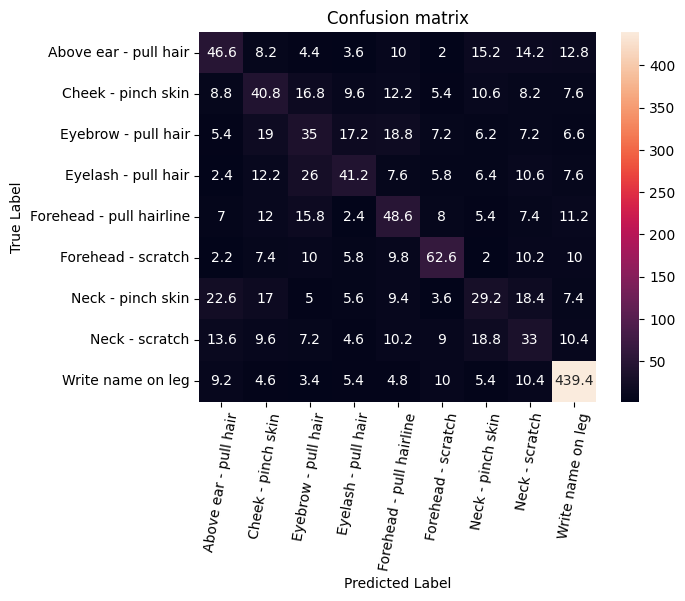

In [24]:
fold = get_avg_fold(folds_score)

macro = fold["f1_macro"]
binary = fold["f1_binary"]

competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.3f}, binary: {binary:.3f}, competition: {competition_eval:.3f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

# macro: 42.6%

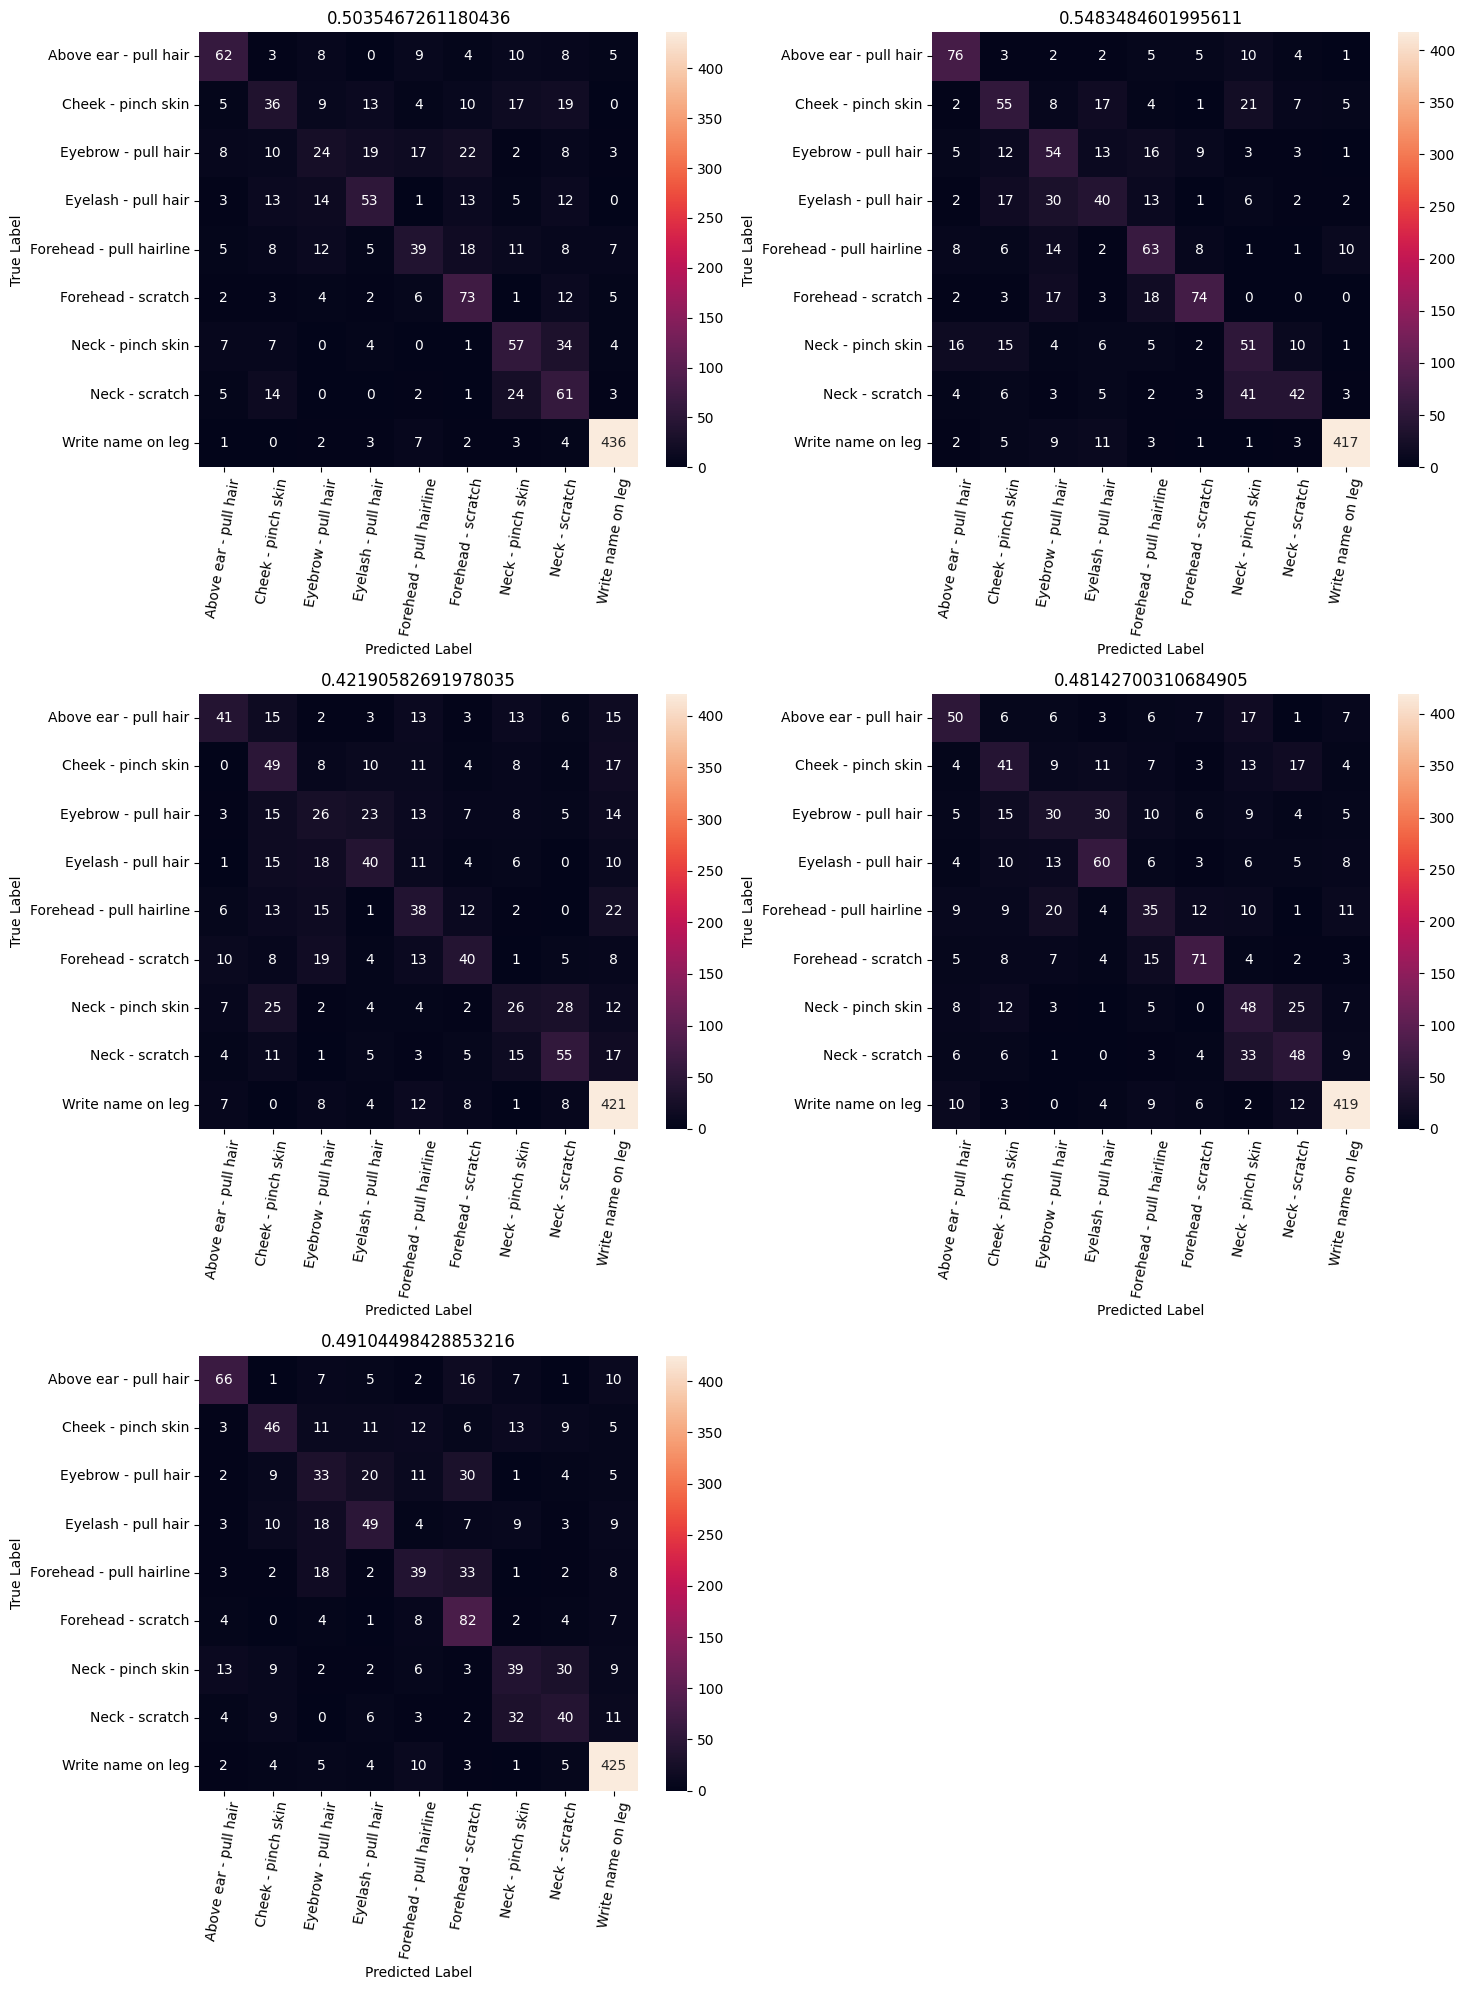

In [57]:
plt.figure(figsize=(15, 20))
for i, fold in enumerate(folds_score, start=1):
    plt.subplot(3, 2, i)
    plot_cm(fold["confusion_matrix"], list(encoder.classes_))
    plt.title(fold['f1_macro'])

plt.tight_layout()
# plt.subplots_adjust(hspace=0.8)

good subjects: ['SUBJ_003328' 'SUBJ_004117' 'SUBJ_017499' 'SUBJ_020948' 'SUBJ_027671'
 'SUBJ_030676' 'SUBJ_036450' 'SUBJ_040282' 'SUBJ_040733' 'SUBJ_041770'
 'SUBJ_047636' 'SUBJ_052342' 'SUBJ_053906' 'SUBJ_054811' 'SUBJ_056936'
 'SUBJ_058967']
bad subjects: ['SUBJ_008304' 'SUBJ_013623' 'SUBJ_019262' 'SUBJ_019756' 'SUBJ_023739'
 'SUBJ_024137' 'SUBJ_026460' 'SUBJ_032233' 'SUBJ_038277' 'SUBJ_040106'
 'SUBJ_042779' 'SUBJ_042794' 'SUBJ_045235' 'SUBJ_050642' 'SUBJ_059960']


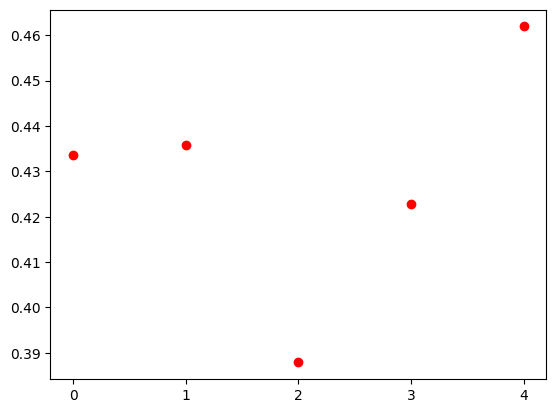

In [359]:
macros = [f["f1_macro"] for f in folds_score]
plt.plot(np.arange(len(macros)), macros, 'ro')
plt.xticks(np.arange(len(macros)))

bad_idx = 2
good_idx = 4

print(f'good subjects: {test_subjects[good_idx]}')
print(f'bad subjects: {test_subjects[bad_idx]}')

KeyboardInterrupt: 

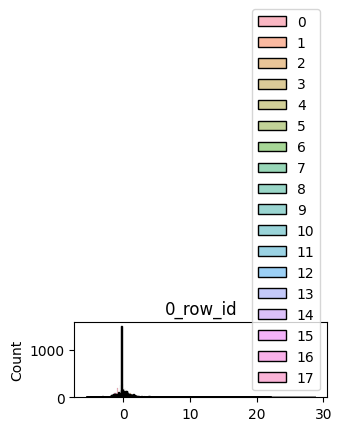

In [275]:
# sub_df = pd.DataFrame(
#     {
#         "value": np.concat([data_good, data_bad]),
#         "fold": ["good"] * len(data_good) + ["bad"] * len(data_bad),
#     }
# )


graph_idx = 1
plt.figure(figsize=(15, 15))
for feature_idx in range(0, X_train_arr[0].shape[1]):
    data_good = X_test_arr[good_idx][:, feature_idx]
    data_bad = X_test_arr[bad_idx][:, feature_idx]

    plt.subplot(13, 4, graph_idx)
    plt.title(f"{feature_idx}_{filtered_df.columns[feature_idx]}")
    sns.histplot(data_good, label="good")
    sns.histplot(data_bad, alpha=0.7, label="bad")
    plt.legend()

    graph_idx += 1

plt.tight_layout()

<Axes: ylabel='Count'>

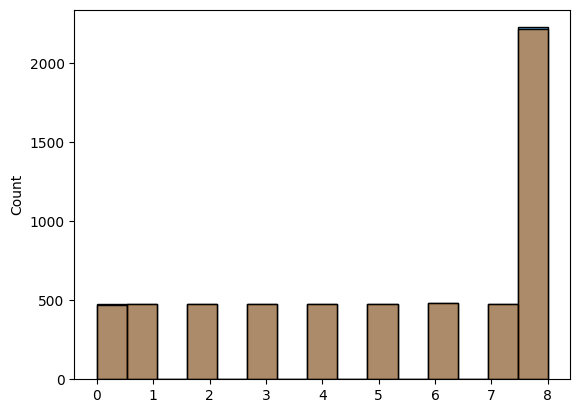

In [276]:
sns.histplot(y_train_arr[good_idx])
sns.histplot(y_train_arr[bad_idx], alpha=0.5)

In [ ]:
# final train model
n_epochs = 400
model = SimpleModel(len(encoder.classes_))

# TODO NORMALIZE DATA
dataset_all = TensorDataset(features_tensor, target_tensor)
dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True)

train_model(model, dataloader_all, n_epochs, should_log=True)
torch.save(model.state_dict, '../models/model.pth')

0 - loss_avg: 1.7670864285901189
20 - loss_avg: 1.3435163935646415
40 - loss_avg: 1.2941331644542515
60 - loss_avg: 1.2580602089874446
80 - loss_avg: 1.2367916163057089
100 - loss_avg: 1.2189869447611272
120 - loss_avg: 1.2041548932902515
140 - loss_avg: 1.1891458523459733
160 - loss_avg: 1.1784265250898898
180 - loss_avg: 1.1631644000299275
200 - loss_avg: 1.1489455755800009
220 - loss_avg: 1.1393039487302303
240 - loss_avg: 1.130943219177425
260 - loss_avg: 1.1241767010651529
280 - loss_avg: 1.1117427400313318
300 - loss_avg: 1.1023416174575686
320 - loss_avg: 1.0911986152641475
340 - loss_avg: 1.0916559724137187
360 - loss_avg: 1.0821397854015231
380 - loss_avg: 1.0796014992520213
